# Optimizers Comparisons

In this project, we are going to use and compare different optimizers on the classic CIFAR10 image classification task, image generation tasks, and also on machine translation tasks, not only including some classic optimizers like Adam, and SGD, but also including some new optimizers like KOALA, which was proposed in [paper](https://arxiv.org/pdf/2107.03331), and you can also add some other

Also, we are going to do some visualizations of different optimizers to see the effects of the gradient descent procedure.

## Google Colab Setup
Before getting started we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [1]:
%load_ext autoreload
%autoreload 2

Then, we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.
Run the following cell to mount your Google Drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the project:

In [3]:
import os

# TODO: Fill in the Google Drive path where you uploaded the project
# Example: If you create a 2020FA folder and put all the files under A1 folder, then '2020FA/A1'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '2020FA/A1'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Koala'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Optimizers_in_DL.ipynb', 'pytorch101.py', '__pycache__', 'Image_Classification']


In the very last step of the environment setup procedure, we need to go into the current directory by using the following command to go into the current folder, you can change the folder name and the path if you want.

In [4]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

from pytorch101 import hello
hello()

pytorch101_path = os.path.join(GOOGLE_DRIVE_PATH, 'pytorch101.py')
pytorch101_edit_time = time.ctime(os.path.getmtime(pytorch101_path))
print('pytorch101.py last edited on %s' % pytorch101_edit_time)

Hello from hello_pytorch.py!
pytorch101.py last edited on Mon Jan 20 08:21:21 2025


## Optimizers

In [5]:
import torch
import torch.optim as optim

def _adadelta(parameters, **kwargs):
    return optim.Adadelta(parameters, **kwargs)


def _adagrad(parameters, **kwargs):
    return optim.Adagrad(parameters, **kwargs)


def _adam(parameters, **kwargs):
    return optim.Adam(parameters, **kwargs)


def _rmsprop(parameters, **kwargs):
    return optim.RMSprop(parameters, **kwargs)


def _sgd(parameters, **kwargs):
    return optim.SGD(parameters, **kwargs)

In [6]:
"""Implementation of AdaFisher/AdaFisherW"""

from typing import Callable, Dict, List, Union, Tuple, Type
from torch import (Tensor, kron, is_grad_enabled, no_grad, zeros_like,
                   preserve_format, ones_like, cat, einsum, sum, inf)
from torch.optim import Optimizer
import torch.distributed as dist
from torch.nn.functional import pad
from math import prod
from torch.nn import Module, Linear, Conv2d, BatchNorm2d, LayerNorm, Parameter


def smart_detect_inf(tensor: Tensor) -> Tensor:
    """
    Replaces positive infinity in the tensor with 1. and negative infinity with 0..

    Parameters:
    tensor (torch.Tensor): Input tensor that can have any dimension.

    Returns:
    torch.Tensor: A tensor with the same shape, dtype, and device as the input, where
                  positive infinities are replaced by 1. and negative infinities by 0..
    """
    result_tensor = tensor.clone()
    result_tensor[tensor == inf] = 1.
    result_tensor[tensor == -inf] = 0.
    return result_tensor


def MinMaxNormalization(tensor: Tensor, epsilon: float = 1e-6) -> Tensor:
    """
    Scales tensor values to range [0,1] using min-max normalization.

    Args:
        tensor: Input tensor
        epsilon: Small value to prevent division by zero (default: 1e-6)

    Returns:
        Normalized tensor with values in [0,1]
    """
    tensor = smart_detect_inf(tensor)
    min_tensor = tensor.min()
    max_tensor = tensor.max()
    range_tensor = max_tensor - min_tensor
    return tensor.add_(-min_tensor).div_(range_tensor + epsilon)


def update_running_avg(new: Tensor, current: Tensor, gamma: float):
    """
    Updates exponential moving average of parameters in-place.

    Args:
        new: New parameter values
        current: Current parameter values to update
        gamma: Smoothing coefficient (0-1)
    """
    current *= gamma * 1e-1
    current += (gamma * 1e-2) * new


def _extract_patches(x: Tensor, kernel_size: Tuple[int],
                     stride: Tuple[int],
                     padding: Tuple[int],
                     groups: int) -> Tensor:

    """
    Extracts sliding window patches from input feature maps for convolution operations.

    Args:
        x: Input tensor (batch_size, in_channels, height, width)
        kernel_size: Height and width of kernel (h, w)
        stride: Step size for sliding window (h, w)
        padding: Input padding (h, w)
        groups: Number of groups for grouped convolution

    Returns:
        Reshaped patches tensor (batch_size, output_h, output_w, in_channels * kernel_h * kernel_w)
    """

    if padding[0] + padding[1] > 0:
        x = pad(x, (padding[1], padding[1], padding[0], padding[0]))
    batch_size, in_channels, height, width = x.size()
    x = x.view(batch_size, groups, in_channels // groups, height, width)
    x = x.unfold(3, kernel_size[0], stride[0])
    x = x.unfold(4, kernel_size[1], stride[1])
    x = x.permute(0, 1, 3, 4, 2, 5, 6).contiguous()
    x = x.view(batch_size, groups, -1, in_channels // groups * kernel_size[0] * kernel_size[1])
    x = x.view(batch_size, -1, x.size(2), x.size(3))
    return x


class Compute_H_D:
    """
    Computes diagonal elements of activation covariance matrices for different neural network layers.
    """

    @classmethod
    def compute_H_D(cls, h, layer) -> Tensor:
        """
        Computes diagonal of activation covariance matrix.

        Args:
            h: Input activations
            layer: PyTorch layer (Linear, Conv2d, BatchNorm2d, or LayerNorm)

        Returns:
            Diagonal elements of covariance matrix
        """
        return cls.__call__(h, layer)

    @classmethod
    def __call__(cls, h: Tensor, layer: Module) -> Tensor:
        """
        Delegates computation to layer-specific methods.

        Args:
            h: Input activations
            layer: PyTorch layer

        Returns:
            Covariance matrix diagonal
        """
        if isinstance(layer, Linear):
            H_D = cls.linear(h, layer)
        elif isinstance(layer, Conv2d):
            H_D = cls.conv2d(h, layer)
        elif isinstance(layer, BatchNorm2d):
            H_D = cls.batchnorm2d(h, layer)
        elif isinstance(layer, LayerNorm):
            H_D = cls.layernorm(h, layer)
        else:
            raise NotImplementedError

        return H_D

    @staticmethod
    def conv2d(h: Tensor, layer: Conv2d) -> Tensor:
        """
        Computes covariance diagonal for Conv2d layer.

        Args:
            h: Input (batch_size, in_channels, height, width)
            layer: Conv2d layer

        Returns:
            Covariance diagonal
        """
        batch_size = h.size(0)
        h = _extract_patches(h, layer.kernel_size, layer.stride, layer.padding, layer.groups)
        spatial_size = h.size(2) * h.size(3)
        h = h.reshape(-1, h.size(-1))
        if layer.bias is not None:
            h_bar = cat([h, h.new(h.size(0), 1).fill_(1)], 1)
        return einsum('ij,ij->j', h_bar, h_bar) / (batch_size * spatial_size) if layer.bias is not None \
            else einsum('ij,ij->j', h, h) / (batch_size * spatial_size)

    @staticmethod
    def linear(h: Tensor, layer: Linear) -> Tensor:
        """
        Computes covariance diagonal for Linear layer.

        Args:
            h: Input activations
            layer: Linear layer

        Returns:
            Covariance diagonal
        """
        if len(h.shape) > 2:
            h = h.reshape(-1, h.shape[-1])
        batch_size = h.size(0)
        if layer.bias is not None:
            h_bar = cat([h, h.new(h.size(0), 1).fill_(1)], 1)
        return einsum('ij,ij->j', h_bar, h_bar) / batch_size if layer.bias is not None \
            else einsum('ij,ij->j', h, h) / batch_size

    @staticmethod
    def batchnorm2d(h: Tensor, layer: BatchNorm2d) -> Tensor:
        """
        Computes covariance diagonal for BatchNorm2d layer.

        Args:
            h: Input activations
            layer: BatchNorm2d layer

        Returns:
            Covariance diagonal
        """
        batch_size, spatial_size = h.size(0), h.size(2) * h.size(3)
        sum_h = sum(h, dim=(0, 2, 3)).unsqueeze(1) / (spatial_size ** 2)
        h_bar = cat([sum_h, sum_h.new(sum_h.size(0), 1).fill_(1)], 1) # 1st column for H of beta parameter
        return einsum('ij,ij->j', h_bar, h_bar) / (batch_size ** 2)

    @staticmethod
    def layernorm(h: Tensor, layer: LayerNorm) -> Tensor:
        """
        Computes covariance diagonal for LayerNorm layer.

        Args:
            h: Input activations
            layer: LayerNorm layer

        Returns:
            Covariance diagonal
        """
        dim_to_reduce = [d for d in range(h.ndim) if d != 1] # T in the paper
        batch_size, dim_norm = h.shape[0], prod([h.shape[dim] for dim in dim_to_reduce if dim != 0])
        sum_h = sum(h, dim=dim_to_reduce).unsqueeze(1) / (dim_norm ** 2)
        h_bar = cat([sum_h, sum_h.new(sum_h.size(0), 1).fill_(1)], 1) # 1st column for H of beta parameter
        return einsum('ij,ij->j', h_bar, h_bar) / (batch_size ** 2)


class Compute_S_D:
    """
    Computes diagonal elements of gradient covariance matrices for different neural network layers.
    """

    @classmethod
    def compute_S_D(cls, s: Tensor, layer: Module) -> Tensor:
        """
        Computes gradient covariance matrix diagonal.

        Args:
            s: Output gradients
            layer: PyTorch layer (Conv2d, Linear, BatchNorm2d, or LayerNorm)

        Returns:
            Diagonal elements of gradient covariance matrix
        """
        return cls.__call__(s, layer)

    @classmethod
    def __call__(cls, s: Tensor, layer: Module) -> Tensor:
        """
        Delegates computation to layer-specific methods.

        Args:
            s: Output gradients
            layer: PyTorch layer

        Returns:
            Covariance matrix diagonal
        """
        if isinstance(layer, Conv2d):
            S_D = cls.conv2d(s, layer)
        elif isinstance(layer, Linear):
            S_D = cls.linear(s, layer)
        elif isinstance(layer, BatchNorm2d):
            S_D = cls.batchnorm2d(s, layer)
        elif isinstance(layer, LayerNorm):
            S_D = cls.layernorm(s, layer)
        else:
            raise NotImplementedError
        return S_D

    @staticmethod
    def conv2d(s: Tensor, layer: Conv2d) -> Tensor:
        """
        Computes gradient covariance diagonal for Conv2d.

        Args:
            s: Gradients (batch_size, n_filters, out_h, out_w)
            layer: Conv2d layer

        Returns:
            Covariance diagonal
        """
        batch_size = s.shape[0]
        spatial_size = s.size(2) * s.size(3)
        s = s.transpose(1, 2).transpose(2, 3)
        s = s.reshape(-1, s.size(-1))
        return einsum('ij,ij->j', s, s) / (batch_size * spatial_size)

    @staticmethod
    def linear(s: Tensor, layer: Linear) -> Tensor:
        """
        Computes gradient covariance diagonal for Linear layer.

        Args:
            s: Output gradients
            layer: Linear layer

        Returns:
            Covariance diagonal
        """
        if len(s.shape) > 2:
            s = s.reshape(-1, s.shape[-1])
        batch_size = s.size(0)
        return einsum('ij,ij->j', s, s) / batch_size

    @staticmethod
    def batchnorm2d(s: Tensor, layer: BatchNorm2d) -> Tensor:
        """
        Computes gradient covariance diagonal for BatchNorm2d.

        Args:
            s: Output gradients
            layer: BatchNorm2d layer

        Returns:
            Covariance diagonal
        """
        batch_size = s.size(0)
        sum_s = sum(s, dim=(0, 2, 3))
        return einsum('i,i->i', sum_s, sum_s) / batch_size

    @staticmethod
    def layernorm(s: Tensor, layer: LayerNorm) -> Tensor:
        """
        Computes gradient covariance diagonal for LayerNorm.

        Args:
            s: Output gradients
            layer: LayerNorm layer

        Returns:
            Covariance diagonal
        """
        batch_size = s.size(0)
        sum_s = sum(s, dim=tuple(range(s.ndim - 1)))
        return einsum('i,i->i', sum_s, sum_s) / batch_size

class AdaFisherBackBone(Optimizer):
    """
    The AdaFisherBackBone class serves as the base class for optimizers that adjust model parameters
    based on the Fisher Information Matrix to more efficiently navigate the curvature of the loss landscape.
    This class is designed to work with neural network models and supports specific module types
    for which Fisher Information can be effectively computed.

    The class initializes with model-related parameters and configurations for the optimizer,
    including learning rate adjustments and regularization techniques based on the second-order
    information. It integrates advanced techniques such as dynamic preconditioning with the Fisher
    Information to stabilize and speed up the convergence of the training process.

    Attributes:
        SUPPORTED_MODULES (Tuple[Type[str], ...]): A tuple listing the types of model modules (layers)
        supported by this optimizer. Typical supported types include "Linear", "Conv2d",
        "BatchNorm2d", and "LayerNorm".

    Args:
        model (Module): The neural network model to optimize.
        lr (float, optional): Learning rate for the optimizer. Defaults to 1e-3.
        beta (float, optional): The beta parameter for the optimizer, used in calculations
                                like those in momentum. Defaults to 0.9.
        Lambda (float, optional): Regularization parameter. Defaults to 1e-3.
        gammas (List[float], optional): A list containing gamma parameters used in the
                                        running average computations. Defaults to [0.92, 0.008].
        TCov (int, optional): Interval in steps for recalculating the covariance matrices. Defaults to 100.
        weight_decay (float, optional): Weight decay coefficient to help prevent overfitting. Defaults to 0.
        dist (bool, optional): True when using a Mutli-GPUs environment, otherwise False.

    Raises:
        ValueError: If any of the parameters are out of their expected ranges.
    """

    SUPPORTED_MODULES: Tuple[Type[str], ...] = ("Linear", "Conv2d", "BatchNorm2d", "LayerNorm")

    def __init__(self,
                 model: Module,
                 lr: float = 1e-3,
                 beta: float = 0.9,
                 Lambda: float = 1e-3,
                 gamma: float = 0.8,
                 TCov: int = 100,
                 weight_decay: float = 0,
                 dist: bool = False
                 ):
        if not 0.0 <= lr:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= beta < 1.0:
            raise ValueError(f"Invalid beta parameter: {beta}")
        if not 0.0 <= gamma < 1.0:
            raise ValueError(f"Invalid gamma parameter: {gamma}")
        if not TCov > 0:
            raise ValueError(f"Invalid TCov parameter: {TCov}")
        defaults = dict(lr=lr, beta=beta,
                        weight_decay=weight_decay)

        self.gamma = gamma
        self.Lambda = Lambda
        self.model = model
        self.TCov = TCov
        self.dist = dist
        self.steps = 0

        # store vectors for the pre-conditioner
        self.H_D: Dict[Module, Tensor] = {}
        self.S_D: Dict[Module, Tensor] = {}
        # save the layers of the network where FIM can be computed
        self.modules: List[Module] = []
        self.Compute_H_D = Compute_H_D()
        self.Compute_S_D = Compute_S_D()
        self._prepare_model()
        super(AdaFisherBackBone, self).__init__(model.parameters(), defaults)

    def _save_input(self, module: Module, input: Tensor, output: Tensor):
        """
        Updates diagonal elements of activation covariance matrix periodically.

        Args:
            module: Neural network layer
            input: Layer input tensor (first element used)
            output: Layer output tensor (unused)

         Note:
            Attaches as forward hook to track layer activations for AdaFisher optimization.
        """
        if is_grad_enabled() and self.steps % self.TCov == 0:
            H_D_i = self.Compute_H_D(input[0].data, module)
            if self.steps == 0:
                self.H_D[module] = H_D_i.new(H_D_i.size(0)).fill_(1)
            update_running_avg(MinMaxNormalization(H_D_i), self.H_D[module], self.gamma)


    def _save_grad_output(self, module: Module, grad_input: Tensor, grad_output: Tensor):
        """
        Updates diagonal elements of gradient covariance matrix periodically.

        Args:
            module: Neural network layer
            grad_input: Input gradients (unused)
            grad_output: Output gradients (first element used)

        Note:
            Attaches as backward hook to track layer gradients for AdaFisher optimization.
        """
        if self.steps % self.TCov == 0:
            S_D_i = self.Compute_S_D(grad_output[0].data, module)
            if self.steps == 0:
                self.S_D[module] = S_D_i.new(S_D_i.size(0)).fill_(1)
            update_running_avg(MinMaxNormalization(S_D_i), self.S_D[module], self.gamma)

    def _prepare_model(self):
        """
        Registers hooks on supported layers to track activations and gradients.

        Warning:
            Avoid in-place operations (e.g., relu(inplace=True) or '*=') in model layers
            as they can interfere with hook functionality.
        """
        for module in self.model.modules():
            classname = module.__class__.__name__
            if classname in self.SUPPORTED_MODULES:
                self.modules.append(module)
                module.register_forward_hook(self._save_input)
                module.register_full_backward_hook(self._save_grad_output)

    def state_dict(self):
        """Save the Kronecker factors in the dictionary state of the optimizer

        Returns:
            Dict[str:List[Tensor]]: Dictionnary containing the states of the optimizer
        """
        state_dict = super().state_dict()
        # Save H_D and S_D as lists ordered by self.modules
        state_dict['H_D'] = [self.H_D[module] for module in self.modules]
        state_dict['S_D'] = [self.S_D[module] for module in self.modules]
        state_dict['steps'] = self.steps
        return state_dict

    def load_state_dict(self, state_dict):
        """Load the Kronecker factors from the dictionary state of the optimizer

        Args:
            state_dict (Dict[str:List[Tensor]]): Dictionnary containing the states of the optimizer
        """
        H_D_list = state_dict.pop('H_D', [])
        S_D_list = state_dict.pop('S_D', [])
        self.steps = state_dict.pop('steps', 0)
        # Load standard parameter states
        super().load_state_dict(state_dict)
        # Rebuild H_D and S_D dictionaries
        self.H_D = {}
        self.S_D = {}
        for module, h_bar, s in zip(self.modules, H_D_list, S_D_list):
            self.H_D[module] = h_bar
            self.S_D[module] = s

    def aggregate_kronecker_factors(self, module: Module):
        """
        Aggregates Kronecker factors across multiple GPUs in a distributed setting.

        This function performs an all-reduce operation to sum the Kronecker factors
        `H_D` and `S_D` across all GPUs involved in the training. It then averages
        these factors by dividing the summed values by the total number of GPUs (`world_size`).

        Args:
            module (Module): The neural network module for which the Kronecker factors
                            `H_D` and `S_D` are being aggregated.
        """
        dist.all_reduce(self.H_D[module], op=dist.ReduceOp.SUM)
        dist.all_reduce(self.S_D[module], op=dist.ReduceOp.SUM)

        self.H_D[module] /= dist.get_world_size()
        self.S_D[module] /= dist.get_world_size()

    def _get_F_tilde(self, module: Module):
        """
        Computes Fisher Information Matrix with regularization for parameter updates.

        Args:
            module: Neural network layer

        Returns:
            - For layers with bias: [weight_update, bias_update]
            - For layers without bias: weight_update tensor

        Note:
            Uses Kronecker product of activation and gradient covariance diagonals.
        """
        # Fisher Computation
        if self.dist:
            self.aggregate_kronecker_factors(module = module)
        F_tilde = kron(self.H_D[module].unsqueeze(1), self.S_D[module].unsqueeze(0)).t() + self.Lambda
        if module.bias is not None:
            F_tilde = [F_tilde[:, :-1], F_tilde[:, -1:]]
            F_tilde[0] = F_tilde[0].view(*module.weight.grad.data.size())
            F_tilde[1] = F_tilde[1].view(*module.bias.grad.data.size())
            return F_tilde
        else:
            return F_tilde.reshape(module.weight.grad.data.size())

    def _check_dim(self, param: List[Parameter], idx_module: int, idx_param: int) -> bool:
        """
        Checks if the dimensions of a given parameter match the dimensions of its corresponding module's weights or bias.
        This function is crucial for ensuring that the Fisher information is available for a specific module.

        Parameters:
            - param (List[Parameter]): A list of all parameters within the model.
            - idx_module (int): The index of the module within the model's modules list.
            - idx_param (int): The index of the parameter within the list of parameters being checked.

        Returns:
            - bool: True if the parameter's dimensions match those of the corresponding module's weights or bias
            (Fisher information is available);
            False otherwise.
        """
        params = param[idx_param]
        module = self.modules[idx_module]
        param_size = params.data.size()
        return param_size == module.weight.data.size() or (module.bias is not None and param_size == module.bias.data.size())


class AdaFisher(AdaFisherBackBone):
    """AdaFisher Optimizer: An adaptive learning rate optimizer that leverages Fisher Information for parameter updates.

       This class AdaFisher optimizer extends traditional optimization techniques by incorporating Fisher Information to
       adaptively adjust the learning rates based on the curvature of the loss landscape. This approach aims to enhance
       convergence stability and speed by scaling updates according to the inverse curvature of the parameter space,
       making it particularly suited for deep learning models where the loss landscape can be highly non-convex.

       Key Features:
           - Adaptive Learning Rates: Adjusts learning rates based on Fisher Information, potentially leading to faster
           convergence by taking more informed steps.
           - Curvature-aware Updates: Utilizes the curvature of the loss landscape to modulate the update steps, aiming
           to improve optimization efficiency.
           - Support for Custom Modules: Designed to work with a wide range of neural network architectures by allowing
           flexible mappings between parameters and modules.

       Usage:
       AdaFisher should be used similarly to other PyTorch optimizers, with the additional step of preparing the model
       by registering necessary hooks to compute Fisher Information:

       ```python
       import torch
       model = MyModel()
       optimizer = AdaFisher(model, lr=1e-3, beta=0.9, gamma=[0.92, 0.008], Lambda=1e-3, weight_decay=0)

       for input, target in dataset:
           optimizer.zero_grad()
           output = model(input)
           loss = loss_fn(output, target)
           loss.backward()
           optimizer.step()
       ```
       """
    def __init__(self,
                 model: Module,
                 lr: float = 1e-3,
                 beta: float = 0.9,
                 Lambda: float = 1e-3,
                 gamma: float = 0.8,
                 TCov: int = 100,
                 weight_decay: float = 0,
                 dist: bool = False
                ):
        super(AdaFisher, self).__init__(model,
                                        lr = lr,
                                        beta = beta,
                                        Lambda = Lambda,
                                        gamma = gamma,
                                        TCov = TCov,
                                        dist = dist,
                                        weight_decay = weight_decay)

    @no_grad()
    def _step(self, hyperparameters: Dict[str, float], param: Parameter, F_tilde: Tensor):
        """
        Updates a single parameter using AdaFisher optimization step.

        Args:
            hyperparameters: Dict containing 'lr', 'beta', and 'weight_decay'
            param: Parameter tensor to update
            F_tilde: Fisher information tensor for parameter

        Note:
            Uses bias-corrected moving averages and Fisher information for adaptive updates.
            Modifies parameter in-place.
        """
        grad = param.grad
        state = self.state[param]
        # State initialization
        if len(state) == 0:
            state['step'] = 0
            # Exponential moving average of gradient values
            state['exp_avg'] = zeros_like(
                param, memory_format=preserve_format)
        exp_avg = state['exp_avg']
        beta = hyperparameters['beta']
        state['step'] += 1
        bias_correction = 1 - beta ** state['step']
        if hyperparameters['weight_decay'] != 0:
            grad = grad.add(param, alpha=hyperparameters['weight_decay'])
        # Decay the first and second moment running average coefficient
        exp_avg.mul_(beta).add_(grad, alpha= 1 - beta)
        step_size = hyperparameters['lr'] / bias_correction
        # Update Rule
        param.addcdiv_(exp_avg, F_tilde, value=-step_size)

    @no_grad()
    def step(self, closure: Union[None, Callable[[], Tensor]] = None):
        """
        Performs a single optimization step across all parameter groups of the model.
        This method iterates over each parameter group, updating parameters based on their gradients, a set of
        hyperparameters, and update tensors calculated for each corresponding module. The update process carefully
        tracks the relationship between parameters and their corresponding modules, using index tracking and dimension
        checks to ensure updates are applied accurately.

        Arguments:
            - closure (callable, optional): A closure that reevaluates the model and returns the loss. Currently,
            the use of closure is not supported, and attempting to provide one will raise a NotImplementedError.

        The update process involves:
            1. Iterating through each parameter group and its corresponding hyperparameters.
            2. For each parameter, checking if a gradient is available. If not, it skips to the next parameter.
            3. Using index tracking to associate parameters with their corresponding modules, considering cases
            where parameters do not have gradients or are part of buffer counts.
            4. Performing a dimensionality check to ensure compatibility between the parameter and module,
            then calculating the update curvature tensor.
            5. Applying the update curvature using a custom step function that incorporates the calculated update
            tensor and hyperparameters.
        """
        if closure is not None:
            raise NotImplementedError("Closure not supported.")
        for group in self.param_groups:
            idx_param, idx_module, buffer_count = 0, 0, 0
            param, hyperparameters = group['params'], {"weight_decay": group['weight_decay'], "beta": group['beta'], "lr": group['lr']}
            for _ in range(len(self.modules)):
                if param[idx_param].grad is None:
                    idx_param += 1
                    if param[idx_param].ndim > 1:
                        idx_module += 1
                    else:
                        buffer_count += 1
                    if buffer_count == 2:
                        idx_module += 1
                        buffer_count = 0
                    continue
                m = self.modules[idx_module]
                if self._check_dim(param, idx_module, idx_param):
                    F_tilde = self._get_F_tilde(m)
                    idx_module += 1
                else:
                    F_tilde = ones_like(param[idx_param])
                if isinstance(F_tilde, list):
                    for F_tilde_i in F_tilde:
                        self._step(hyperparameters, param[idx_param], F_tilde_i)
                        idx_param += 1
                else:
                    self._step(hyperparameters, param[idx_param], F_tilde)
                    idx_param += 1
        self.steps += 1


class AdaFisherW(AdaFisherBackBone):
    """AdaFisherW Optimizer: An adaptive learning rate optimizer that leverages Fisher Information for parameter updates.

   The AdaFisherW optimizer extends traditional optimization techniques by incorporating Fisher Information to
   adaptively adjust the learning rates based on the curvature of the loss landscape. This approach aims to enhance
   convergence stability and speed by scaling updates according to the inverse curvature of the parameter space,
   making it particularly suited for deep learning models where the loss landscape can be highly non-convex.

   Key Features:
       - Adaptive Learning Rates: Adjusts learning rates based on Fisher Information, potentially leading to faster
       convergence by taking more informed steps.
       - Curvature-aware Updates: Utilizes the curvature of the loss landscape to modulate the update steps, aiming
       to improve optimization efficiency.
       - Support for Custom Modules: Designed to work with a wide range of neural network architectures by allowing
       flexible mappings between parameters and modules.

   Usage:
   AdaFisherW should be used similarly to other PyTorch optimizers, with the additional step of preparing the model
   by registering necessary hooks to compute Fisher Information:

   ```python
   import torch
   model = MyModel()
   optimizer = AdaFisherW(model, lr=1e-3, beta=0.9, gamma=[0.98, 0.008], Lambda=1e-3, weight_decay=0)

   for input, target in dataset:
       optimizer.zero_grad()
       output = model(input)
       loss = loss_fn(output, target)
       loss.backward()
       optimizer.step()
   ```
    """
    def __init__(self,
                 model: Module,
                 lr: float = 1e-3,
                 beta: float = 0.9,
                 Lambda: float = 1e-3,
                 gamma: float = 0.8,
                 TCov: int = 100,
                 weight_decay: float = 0,
                 dist: bool = False
                ):
        super(AdaFisherW, self).__init__(model,
                                        lr = lr,
                                        beta = beta,
                                        Lambda = Lambda,
                                        gamma = gamma,
                                        TCov = TCov,
                                        dist = dist,
                                        weight_decay = weight_decay)

    @no_grad()
    def _step(self, hyperparameters: Dict[str, float], param: Parameter, F_tilde: Tensor):
        """
        Updates a single parameter using AdaFisherW optimization step.

        Args:
            hyperparameters: Dict containing 'lr', 'beta', and 'weight_decay'
            param: Parameter tensor to update
            F_tilde: Fisher information tensor for parameter

        Note:
            Uses bias-corrected moving averages and Fisher information for adaptive updates.
            Modifies parameter in-place.
        """
        grad = param.grad
        state = self.state[param]
        # State initialization
        if len(state) == 0:
            state['step'] = 0
            # Exponential moving average of gradient values
            state['exp_avg'] = zeros_like(
                param, memory_format=preserve_format)
        exp_avg = state['exp_avg']
        beta = hyperparameters['beta']
        state['step'] += 1
        bias_correction = 1 - beta ** state['step']
        # Decay the first and second moment running average coefficient
        exp_avg.mul_(beta).add_(grad, alpha= 1 - beta)
        param.data -= hyperparameters['lr'] * (exp_avg / bias_correction / F_tilde + hyperparameters['weight_decay'] * param.data)


    @no_grad()
    def step(self, closure: Union[None, Callable[[], Tensor]] = None):
        """
        Performs a single optimization step across all parameter groups of the model.
        This method iterates over each parameter group, updating parameters based on their gradients, a set of
        hyperparameters, and update tensors calculated for each corresponding module. The update process carefully
        tracks the relationship between parameters and their corresponding modules, using index tracking and dimension
        checks to ensure updates are applied accurately.

        Arguments:
            - closure (callable, optional): A closure that reevaluates the model and returns the loss. Currently,
            the use of closure is not supported, and attempting to provide one will raise a NotImplementedError.

        The update process involves:
            1. Iterating through each parameter group and its corresponding hyperparameters.
            2. For each parameter, checking if a gradient is available. If not, it skips to the next parameter.
            3. Using index tracking to associate parameters with their corresponding modules, considering cases
            where parameters do not have gradients or are part of buffer counts.
            4. Performing a dimensionality check to ensure compatibility between the parameter and module,
            then calculating the update curvature tensor.
            5. Applying the update curvature using a custom step function that incorporates the calculated update
            tensor and hyperparameters.
        """
        if closure is not None:
            raise NotImplementedError("Closure not supported.")
        for group in self.param_groups:
            idx_param, idx_module, buffer_count = 0, 0, 0
            param, hyperparameters = group['params'], {"weight_decay": group['weight_decay'], "beta": group['beta'], "lr": group['lr']}
            for _ in range(len(self.modules)):
                if param[idx_param].grad is None:
                    idx_param += 1
                    if param[idx_param].ndim > 1:
                        idx_module += 1
                    else:
                        buffer_count += 1
                    if buffer_count == 2:
                        idx_module += 1
                        buffer_count = 0
                    continue
                m = self.modules[idx_module]
                if self._check_dim(param, idx_module, idx_param):
                    F_tilde = self._get_F_tilde(m)
                    idx_module += 1
                else:
                    F_tilde = ones_like(param[idx_param])
                if isinstance(F_tilde, list):
                    for F_tilde_i in F_tilde:
                        self._step(hyperparameters, param[idx_param], F_tilde_i)
                        idx_param += 1
                else:
                    self._step(hyperparameters, param[idx_param], F_tilde)
                    idx_param += 1
        self.steps += 1

Besides the classical optimization above, we are also going to use some newly-proposed optimization algorithm, which are KOALA, proposed in [paper](https://arxiv.org/pdf/2107.03331)), and also some other optimizers worth discovering.


The first one is KOALA, an optimization algorithm inspired by the Extended Kalman Filter (EKF). It introduces a dynamic learning rate adjustment mechanism using state estimation and covariance modeling, making it highly effective for large-scale neural network optimization.

### **Mathematical Foundation**
KOALA is based on EKF principles and consists of two main steps:

1. **Predict Step:**
   - State Prediction:
     $\hat{x}_k = f_k(\hat{x}_{k-1})$, In KOALA-V,  $f_k(\hat{x}_{k-1})=\hat{x}_{k-1}$
   - Covariance Prediction:
     $\hat{P}_k = F_k \hat{P}_{k-1} F_k^T + Q_k$, In Koala-V, $Q_k$ is a constant scalar

2. **Update Step:**
   - Kalman Gain:
     $K_k = \hat{P}_k H_k^T (H_k \hat{P}_k H_k^T + R_k)^{-1}$
   - State Update:
     $x_k = \hat{x}_k + K_k (z_k - h_k(\hat{x}_k))$
   - Covariance Update:
     $P_k = (I - K_k H_k) \hat{P}_k$

### **Optimization Version (KOALA-V)**
In optimization tasks, these equations are adapted to update model parameters. The key update rule is:

- $x_k = x_k - \frac{\hat{P}_k (\hat{L}_k(x_k) - \hat{L}_k^{\text{target}})}{\hat{P}_k \|\nabla \hat{L}_k(x_k)\|^2 + R} \nabla \hat{L}_k(x_k)$
- The derivation needs two approximations (at least from my understanding):
    - $h_k(\hat{x}_k)=h_k(x_k)$
    - $\nabla \hat{h}_k(x_k)=\nabla \hat{L}_k(x_k)$



This dynamically scales the gradient step based on the state covariance $\hat{P}_k$, the loss gradient norm $\|\nabla \hat{L}_k(x_k)\|^2$, and the noise covariance $R$.

In [7]:
class ExpAverage(object):
    def __init__(self, alpha, init_val=0):
        self.val = init_val
        self.avg = init_val
        self.alpha = alpha

    def update(self, val):
        self.val = val
        self.avg = self.alpha * self.avg + (1 - self.alpha) * val

    def get_avg(self):
        return self.avg

    def get_last_val(self):
        return self.val

In [8]:
class KOALABase(torch.optim.Optimizer):
    def __init__(self, params, **kwargs):
        defaults = dict(**kwargs)
        super(KOALABase, self).__init__(params, defaults)

    @torch.no_grad()
    def predict(self):
        pass

    @torch.no_grad()
    def update(self, loss: torch.FloatTensor, loss_var: torch.FloatTensor):
        pass


class VanillaKOALA(KOALABase):
    def __init__(
            self,
            params,
            sigma: float = 1,
            q: float = 1,
            r: float = None,
            alpha_r: float = 0.9,
            weight_decay: float = 0.0,
            lr: float = 1,
            **kwargs):
        """
        Implementation of the KOALA-V(Vanilla) optimizer

        :param params: parameters to optimize
        :param sigma: initial value of P_k
        :param q: fixed constant Q_k
        :param r: fixed constant R_k (None for online estimation)
        :param alpha_r: smoothing coefficient for online estimation of R_k
        :param weight_decay: weight decay
        :param lr: learning rate
        :param kwargs:
        """
        super(VanillaKOALA, self).__init__(params, **kwargs)

        self.eps = 1e-9

        for group in self.param_groups:
            group["lr"] = lr

        # Initialize state
        self.state["sigma"] = sigma
        self.state["q"] = q
        if r is not None:
            self.state["r"] = r
        else:
            self.state["r"] = ExpAverage(alpha_r, 1.0)
        self.state["weight_decay"] = weight_decay

    @torch.no_grad()
    def predict(self):
        self.state["sigma"] += self.state["q"]

    @torch.no_grad()
    def update(self, loss: torch.FloatTensor, loss_var: torch.FloatTensor):
        # 如果R_k是动态估计的 (ExpAverage)，则更新，否则使用固定值
        if isinstance(self.state["r"], ExpAverage):
            self.state["r"].update(loss_var)
            cur_r = self.state["r"].get_avg()
        else:
            cur_r = self.state["r"]

        max_grad_entries = list()
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None or p.grad.norm(p=2) < self.eps:
                    continue

                layer_grad = p.grad + self.state["weight_decay"] * p
                layer_grad_norm = layer_grad.norm(p=2)

                s = self.state["sigma"] * (layer_grad_norm ** 2) + cur_r

                layer_loss = loss + 0.5 * self.state["weight_decay"] * p.norm(p=2) ** 2
                scale = group["lr"] * layer_loss * self.state["sigma"] / s
                p.data.add_(-scale * p.grad)

                max_grad_entries.append(layer_grad_norm ** 2 / s)

        hh_approx = torch.max(torch.stack(max_grad_entries))

        self.state["sigma"] -= self.state["sigma"] ** 2 * hh_approx


class MomentumKOALA(KOALABase):
    def __init__(
            self,
            params,
            sw: float = 1e-1,
            sc: float = 0,
            sv: float = 1e-1,
            a: float = 0.9,
            qw: float = 1e-2,
            qv: float = 1e-2,
            r: float = None,
            alpha_r: float = 0.9,
            weight_decay: float = 0.0,
            lr: float = 1,
            **kwargs):
        """
        Implementation of the KOALA-M(Momentum) optimizer

        :param params: parameters to optimize
        :param sw: initial value of P_k for states
        :param sc: initial value of out of diagonal entries of P_k
        :param sv: initial value of P_k for velocities
        :param a: decay coefficient for velocities
        :param qw: fixed constant Q_k for states
        :param qv: fixed constant Q_k for velocities
        :param r: fixed constant R_k (None for online estimation)
        :param alpha_r: smoothing coefficient for online estimation of R_k
        :param weight_decay: weight decay
        :param lr: learning rate
        :param kwargs:
        """
        super(MomentumKOALA, self).__init__(params, **kwargs)

        self.eps = 1e-9

        self.shared_device = self.param_groups[0]["params"][0].device
        self.dtype = torch.double

        # Initialize velocities and count params
        self.total_params = 0
        for group in self.param_groups:
            group["lr"] = lr
            for p in group["params"]:
                self.state[p]["vt"] = p.new_zeros(p.shape)
                self.state[p]["gt"] = p.new_zeros(p.shape)
                self.total_params += torch.prod(torch.Tensor(list(p.size())).to(self.shared_device))

        # Define state
        self.state["Pt"] = torch.Tensor([
            [sw, sc],
            [sc, sv]
        ]).to(self.shared_device).to(self.dtype)

        self.state["qw"] = ExpAverage(0.9, qw)
        self.state["qv"] = qv
        self.state["Q"] = torch.diag(
            torch.Tensor([self.state["qw"].get_avg(), self.state["qv"]])
        ).to(self.shared_device).to(self.dtype)

        if r is not None:
            self.state["R"] = r
        else:
            self.state["R"] = ExpAverage(alpha_r, 1.0)

        f = [[1, 1], [0, a]]
        self.state["F"] = torch.Tensor(f).to(self.shared_device).to(self.dtype)

        self.state["weight_decay"] = weight_decay

    @torch.no_grad()
    def predict(self):
        wdiff = list()
        for group in self.param_groups:
            for p in group["params"]:
                pw_diff = (self.state[p]["gt"] - p).norm(p=2).to(self.shared_device)
                wdiff.append(pw_diff)

                p.mul_(self.state["F"][0, 0].to(p.device))
                p.add_(self.state[p]["vt"] * self.state["F"][0, 1].to(p.device))
                self.state[p]["vt"].mul_(self.state["F"][1, 1].to(p.device))
                self.state[p]["vt"].add_(p * self.state["F"][1, 0].to(p.device))

        norm_wdiff = torch.stack(wdiff).norm(p=2) / self.total_params
        self.state["qw"].update(norm_wdiff)
        self.state["Q"] = torch.diag(
            torch.Tensor([self.state["qw"].get_avg(), self.state["qv"]])
        ).to(self.shared_device).to(self.dtype)

        self.state["Pt"] = torch.matmul(
            torch.matmul(self.state["F"], self.state["Pt"]), self.state["F"].t())
        self.state["Pt"].add_(self.state["Q"])

    @torch.no_grad()
    def update(self, loss: torch.FloatTensor, loss_var: torch.FloatTensor):
        if isinstance(self.state["R"], ExpAverage):
            self.state["R"].update(loss_var.to(self.shared_device))
            cur_r = self.state["R"].get_avg()
        else:
            cur_r = self.state["R"]

        max_grad_entries = list()
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None or p.grad.norm(p=2) < self.eps:
                    continue

                layer_grad = p.grad + self.state["weight_decay"] * p
                layer_grad_norm = layer_grad.norm(p=2)

                S = layer_grad_norm ** 2 * self.state["Pt"][0, 0] + cur_r

                layer_loss = loss.to(self.shared_device) + 0.5 * self.state["weight_decay"] * p.norm(p=2) ** 2
                K1 = self.state["Pt"][0, 0] / S * layer_loss * group["lr"]
                K2 = self.state["Pt"][1, 0] / S * layer_loss * group["lr"]

                # Update weights and velocities
                p.sub_((K1 * layer_grad).to(p.device))
                self.state[p]["vt"].sub_((K2 * layer_grad).to(p.device))

                self.state[p]["gt"].mul_(0.9)
                self.state[p]["gt"].add_(0.1 * p)

                max_grad_entries.append(layer_grad_norm ** 2 / S)

        hh_approx = torch.max(torch.stack(max_grad_entries))

        # Update covariance
        HHS = torch.Tensor([
            [hh_approx, 0],
            [0, 0]
        ]).to(self.shared_device).to(self.dtype)
        PHHS = torch.matmul(self.state["Pt"], HHS)
        PHHSP = torch.matmul(PHHS, self.state["Pt"].t())
        self.state["Pt"] = self.state["Pt"] - PHHSP

# KOALA++

Init: $v_{0}$, $H_{0}$

We know: $S_{k-1}, H_{k-1}, v_{k-1}, H_{k}$

for i in range(1, T):
* $\lambda_{k}=\frac{H_{k}(v_{k-1}^T+QH_{K-1}^T)}{S_{k-1}}$
* $v_{k}=(1-\lambda_{k})v_{k-1}+(H_{k}-\lambda_{k}H_{k-1})Q$
* $S_{k}=v_{k}H_{k}^T+H_{k}QH_{k}^T+R$
* $x_{k}=x_{k-1}-\frac{(\hat{L}_k(x_k) - \hat{L}_k^{\text{target}})}{S_{k}}$$(v_{k}^T+QH_{k}^T)$

In [9]:
import torch
import math
import torch.nn.functional as F

class KOALAPlusPlus(KOALABase):
    def __init__(
            self,
            params,
            sigma: float = 1,
            q: float = 1,
            r: float = None,
            alpha_r: float = 0.9,
            weight_decay: float = 0.0,
            lr: float = 1,
            **kwargs):
        super(KOALAPlusPlus, self).__init__(params, **kwargs)
        self.eps = 1e-9
        for group in self.param_groups:
            group["lr"] = lr

        # 初始化状态（常量以数值形式存储）
        self.state = {}
        self.state["sigma"] = sigma  # σ_0
        self.state["q"] = q          # Q
        if r is not None:
            self.state["r"] = r
        else:
            self.state["r"] = ExpAverage(alpha_r, 1.0)
        self.state["weight_decay"] = weight_decay

        # 初始化每个参数状态（存储 vk、Hk、Sk、Pk）
        for group in self.param_groups:
            for p in group["params"]:
                self.state[p] = {}
                self.state[p]["vk"] = None
                self.state[p]["Hk"] = None
                self.state[p]["Sk"] = None

    @torch.no_grad()
    def predict(self):
        pass


    @torch.no_grad()
    # @torch.cuda.amp.autocast()
    def update(self, loss: torch.FloatTensor, loss_var: torch.FloatTensor):
        # 更新 r 状态
        if isinstance(self.state["r"], ExpAverage):
            self.state["r"].update(loss_var)
            cur_r = self.state["r"].get_avg()
        else:
            cur_r = self.state["r"]

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None or p.grad.norm(2) < self.eps:
                    continue

                p_shape = p.shape
                # 获取上次状态
                vk_prev = self.state[p]["vk"]
                Hk_prev = self.state[p]["Hk"]
                Sk_prev = self.state[p]["Sk"]

                Q = self.state["q"]
                sigma = self.state["sigma"]

                # 计算当前梯度 Hk（拉平成向量），使用 in-place 加法
                Hk = p.grad.view(-1) + self.state["weight_decay"] * p.view(-1)
                # 初始化 vk_prev、Hk_prev 如不存在
                if vk_prev is None:
                    vk_prev = Hk.mul(sigma)
                if Hk_prev is None:
                    Hk_prev = Hk
                # 如果 Sk_prev 未定义，则计算
                if Sk_prev is None:
                    # 计算 dot(vk_prev, Hk_prev) 和 dot(Hk_prev, Hk_prev)
                    Sk_prev = torch.dot(vk_prev.add(Q, alpha=1.0).mul_(Hk_prev), Hk_prev).add_(cur_r)

                # Compute lambda_k
                lambdak = torch.dot(Hk, vk_prev + Q * Hk_prev) / Sk_prev
                alpha = torch.dot(Hk, Hk_prev) / torch.dot(Hk_prev, Hk_prev)
                r_k = torch.dot(Hk, vk_prev) * torch.dot(Hk_prev, Hk_prev) - torch.dot(Hk_prev, vk_prev) * torch.dot(Hk, Hk_prev)
                r_k /= torch.dot(Hk_prev, Hk_prev) ** 2
                vk = (alpha - lambdak) * vk_prev + Q * (Hk - lambdak * Hk_prev) + r_k * Hk_prev
                # 计算新的 Sk: Sk = Pk_hat * dot(Hk, Hk) + cur_r
                Sk_new = torch.dot(vk.add(Hk.mul(Q)), Hk).add_(cur_r)

                # 更新参数：计算 layer_loss
                layer_loss = loss + 0.5 * self.state["weight_decay"] * (p.norm(2) ** 2)
                # scale = - lr * layer_loss * Pk_hat * Hk / Sk_new
                # scale = Hk.clone()  # 创建一个拷贝用于更新
                # scale.div_(Sk_new).mul_(-group["lr"] * layer_loss)
                scale = - group["lr"] * layer_loss * (vk + Q * Hk) / Sk_new
                p.data.add_(scale.view(p_shape))

                # 更新状态
                self.state[p]["vk"] = vk
                self.state[p]["Hk"] = Hk
                self.state[p]["Sk"] = Sk_new




## Part 1: Image Classification

The first task is to use CIFAR10 dataset to do image classification. We wil choose ResNet-based models for the task.

In [10]:
from functools import partial

import torch.nn as nn
import torchvision.models


def _change_to_cifar(m):
    m.conv1 = nn.Conv2d(3, m.conv1.out_channels, kernel_size=3, padding=1, bias=False)
    nn.init.kaiming_normal_(m.conv1.weight, mode='fan_out', nonlinearity='relu')
    m.maxpool = nn.Identity()
    m.relu = nn.ReLU(inplace=False)
    return m


def _resnet18(num_classes, is_cifar=False, **kwargs):
    model = torchvision.models.resnet.ResNet(
        torchvision.models.resnet.BasicBlock,
        [2, 2, 2, 2],
        num_classes=num_classes,
        **kwargs)
    if is_cifar:
        model = _change_to_cifar(model)
    return model


def _resnet50(num_classes, is_cifar=False, **kwargs):
    model = torchvision.models.resnet.ResNet(
        torchvision.models.resnet.Bottleneck,
        [3, 4, 6, 3],
        num_classes=num_classes,
        **kwargs)
    if is_cifar:
        model = _change_to_cifar(model)
    return model


def _wide_resnet_50_2(num_classes, is_cifar=False, **kwargs):
    model = torchvision.models.resnet.ResNet(
        torchvision.models.resnet.Bottleneck,
        [3, 4, 6, 3],
        num_classes=num_classes,
        width_per_group=64 * 2,
        **kwargs)
    if is_cifar:
        model = _change_to_cifar(model)
    return model

In [11]:
import time
import torch
import matplotlib.pyplot as plt

class AverageMeter(object):
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def get_avg(self):
        return self.avg

    def get_last_val(self):
        return self.val

def _accuracy(output, target, top_k=(1,)):
    max_k = max(top_k)
    batch_size = target.size(0)

    _, pred = output.topk(max_k, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in top_k:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        wrong_k = batch_size - correct_k
        res.append(wrong_k.mul_(100.0 / batch_size))

    return res


def train(train_loader, model, criterion, optimizer, scheduler, epoch, num_epochs,
          is_koala=False, print_freq=50, train_loss_history=None, train_top1_history=None, train_top5_history=None):
    # print(type(optimizer))
    # print(is_koala)
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # Switch to train mode
    model.train()
    end = time.time()

    for i, (input, target) in enumerate(train_loader):
        # Measure data loading time
        data_time.update(time.time() - end)

        input = input.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        if is_koala:
            optimizer.predict()

        # Compute output and loss
        output = model(input)
        loss = criterion(output, target)
        loss_mean = loss.mean()

        # Compute gradient and perform update step
        optimizer.zero_grad()
        loss_mean.backward()
        if is_koala:
            # print("asdjajsdh")
            loss_var = torch.mean(torch.pow(loss, 2))
            optimizer.update(loss_mean, loss_var)
        else:
            optimizer.step()

        # Measure accuracy (Top-1 and Top-5 error) and record loss
        err1, err5 = _accuracy(output.data, target, top_k=(1, 5))
        losses.update(loss_mean.item(), input.size(0))
        top1.update(err1.item(), input.size(0))
        top5.update(err5.item(), input.size(0))

        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print(f'Epoch: [{epoch}/{num_epochs}][{i}/{len(train_loader)}]\t'
                  f'Time {batch_time.get_last_val():.3f} ({batch_time.get_avg():.3f})\t'
                  f'Data {data_time.get_last_val():.3f} ({data_time.get_avg():.3f})\t'
                  f'Loss {losses.get_last_val():.4f} ({losses.get_avg():.4f})\t'
                  f'Top 1-err {top1.get_last_val():.4f} ({top1.get_avg():.4f})\t'
                  f'Top 5-err {top5.get_last_val():.4f} ({top5.get_avg():.4f})')

    # Update scheduler after epoch (not after each batch)
    scheduler.step()

    # Store metrics for visualization
    train_loss_history.append(losses.get_avg())
    train_top1_history.append(top1.get_avg())
    train_top5_history.append(top5.get_avg())

    return losses.get_avg(), top1.get_avg(), top5.get_avg()




def validate(val_loader, model, criterion, epoch, num_epochs, print_freq=50,
             val_loss_history=None, val_top1_history=None, val_top5_history=None):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # Switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        input = input.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        with torch.no_grad():
            output = model(input)
            loss = torch.mean(criterion(output, target))

        # Measure accuracy (Top-1 and Top-5 error) and record loss
        err1, err5 = _accuracy(output.data, target, top_k=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(err1.item(), input.size(0))
        top5.update(err5.item(), input.size(0))

        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print(f'Test (on val set): [{epoch}/{num_epochs}][{i}/{len(val_loader)}]\t'
                  f'Time {batch_time.get_last_val():.3f} ({batch_time.get_avg():.3f})\t'
                  f'Loss {losses.get_last_val():.4f} ({losses.get_avg():.4f})\t'
                  f'Top 1-err {top1.get_last_val():.4f} ({top1.get_avg():.4f})\t'
                  f'Top 5-err {top5.get_last_val():.4f} ({top5.get_avg():.4f})')

    print(f'* Epoch: [{epoch}/{num_epochs}]\t'
          f'Top 1-err {top1.get_avg():.3f}\t'
          f'Top 5-err {top5.get_avg():.3f}\t'
          f'Test Loss {losses.get_avg():.3f}')

    # Store metrics for visualization
    val_loss_history.append(losses.get_avg())
    val_top1_history.append(top1.get_avg())
    val_top5_history.append(top5.get_avg())

    return losses.get_avg(), top1.get_avg(), top5.get_avg()



In [12]:
from typing_extensions import final
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
import random
import numpy as np

def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def Trainer(model, optim_name, dataset_name='cifar10', max_epochs=100, random_seed=0):
    """
    Train and evaluate the model on CIFAR-10 dataset.

    Args:
        model: Model to train
        optim_name: Name of the optimizer to use
        max_epochs: Number of epochs

    Returns:
        train_loss_history: List of training loss per epoch
        val_loss_history: List of validation loss per epoch
        train_top1_history: List of training Top-1 error per epoch
        val_top1_history: List of validation Top-1 error per epoch
        train_top5_history: List of training Top-5 error per epoch
        val_top5_history: List of validation Top-5 error per epoch
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    set_random_seed(random_seed)

    # Configure optimizer
    if optim_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0005)
    elif optim_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.0003, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0005)
    elif optim_name == 'KOALA-V':
        optimizer = VanillaKOALA(
            params=model.parameters(),
            sigma=0.1, q=1, r=None, alpha_r=0.9,
            weight_decay=0.0005, lr=0.1
        )
    elif optim_name == 'KOALA-M':
        optimizer = MomentumKOALA(
            params=model.parameters(),
            sw=0.1, sc=0.0, sv=0.1, a=0.9,
            qw=0.01, qv=0.01, r=None, alpha_r=0.9,
            weight_decay=0.0005, lr=1.0
        )
    elif optim_name == 'KOALA-P':
        optimizer = KOALAPlusPlus(
            params=model.parameters(),
            sigma=0.1, q=0.1, r=None, alpha_r=0.9,
            weight_decay=0.0005, lr=1.0
        )
    elif optim_name == 'AdaFisher':
         optimizer = AdaFisher(model, lr=1e-3, beta=0.9, gamma=0.8, Lambda=1e-3, weight_decay=5e-4)
    else:
        raise ValueError(f"Unknown optimizer name: {optim_name}")

    # Learning rate scheduler
    if max_epochs == 100:
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 60, 90], gamma=0.1)
    elif max_epochs == 200:
        # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.1)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
        # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200, eta_min=1e-4)
    else:
        raise ValueError(f"Unknown max_epoch: {max_epochs}")

    # scheduler = CosineAnnealingLR(optimizer, T_max=max_epochs, eta_min=1e-4)

    # Loss function
    criterion = nn.CrossEntropyLoss().to(device)

    # Configure dataset
    normalize = transforms.Normalize(
        mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
        std=[x / 255.0 for x in [63.0, 62.1, 66.7]]
    )
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    if dataset_name == 'cifar10':
      train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train),
        batch_size=128, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

      val_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root="./data", train=False, transform=transform_test),
        batch_size=128, shuffle=False, num_workers=4, pin_memory=True
      )

    else:
      raise ValueError(f"Unknown dataset name: {dataset_name}")
    # Initialize history storage
    train_loss_history, val_loss_history = [], []
    train_top1_history, val_top1_history = [], []
    train_top5_history, val_top5_history = [], []

    # Training Loop
    for epoch in range(max_epochs):
        print(f"\nEpoch {epoch + 1}/{max_epochs}")

        # Train for one epoch
        train_loss, train_top1, train_top5 = train(
            train_loader, model, criterion, optimizer, scheduler, epoch, max_epochs,
            is_koala=("KOALA" in optim_name),
            train_loss_history=train_loss_history,
            train_top1_history=train_top1_history,
            train_top5_history=train_top5_history
        )

        # Validate
        val_loss, val_top1, val_top5 = validate(
            val_loader, model, criterion, epoch, max_epochs,
            val_loss_history=val_loss_history,
            val_top1_history=val_top1_history,
            val_top5_history=val_top5_history
        )

    # ------------------------ #
    # Visualization           #
    # ------------------------ #
    epochs = range(1, max_epochs + 1)

    # Plot Loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss_history, label="Train Loss", marker="o")
    plt.plot(epochs, val_loss_history, label="Validation Loss", marker="s")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Training and Validation Loss ({optim_name})")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Top-1 Error
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_top1_history, label="Train Top-1 Error", marker="o")
    plt.plot(epochs, val_top1_history, label="Validation Top-1 Error", marker="s")
    plt.xlabel("Epochs")
    plt.ylabel("Error (%)")
    plt.title(f"Training and Validation Top-1 Error ({optim_name})")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Top-5 Error
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_top5_history, label="Train Top-5 Error", marker="o")
    plt.plot(epochs, val_top5_history, label="Validation Top-5 Error", marker="s")
    plt.xlabel("Epochs")
    plt.ylabel("Error (%)")
    plt.title(f"Training and Validation Top-5 Error ({optim_name})")
    plt.legend()
    plt.grid(True)
    plt.show()


    print(f"Finished training with {optim_name}.")
    final_val_top1 = val_top1_history[-1]
    # get the best val top-1 error and its corresponding top-5 error
    best_val_top1 = min(val_top1_history)
    best_val_top5 = val_top5_history[val_top1_history.index(best_val_top1)]
    print(f"Best val top1 error: {best_val_top1}")
    print(f"Final val top1 error: {final_val_top1}")
    final_val_top5 = val_top5_history[-1]
    print(f"Best val top5 error: {best_val_top5}")
    print(f"Final val top5 error: {final_val_top5}")
    # val_loss history
    # return train_loss_history, val_loss_history, train_top1_history, val_top1_history, train_top5_history, val_top5_history



In [13]:
'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = out + self.shortcut(x)
        out = self.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = out + self.shortcut(x)
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.layer1 = self._make_layer(block, self.in_planes, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.relu = nn.ReLU(inplace=False)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(num_classes: int = 10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)


def ResNet34(num_classes: int = 10):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)


def ResNet50(num_classes: int = 10):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)


def ResNet101(num_classes: int = 10):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes)


def ResNet152(num_classes: int = 10):
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes)


In [14]:
model1 = ResNet18(num_classes=10)
model2 = ResNet50(num_classes=10)
model3 = ResNet101(num_classes=10)

100%|██████████| 170M/170M [00:02<00:00, 79.0MB/s]



Epoch 1/200
Epoch: [0/200][0/390]	Time 2.089 (2.089)	Data 0.159 (0.159)	Loss 2.4386 (2.4386)	Top 1-err 92.9688 (92.9688)	Top 5-err 53.1250 (53.1250)
Epoch: [0/200][50/390]	Time 0.050 (0.091)	Data 0.000 (0.003)	Loss 2.7794 (6.9092)	Top 1-err 89.8438 (89.9050)	Top 5-err 46.0938 (48.9124)
Epoch: [0/200][100/390]	Time 0.050 (0.071)	Data 0.000 (0.002)	Loss 2.3695 (4.8879)	Top 1-err 87.5000 (89.1476)	Top 5-err 43.7500 (46.6352)
Epoch: [0/200][150/390]	Time 0.050 (0.064)	Data 0.000 (0.001)	Loss 2.3070 (4.1889)	Top 1-err 85.9375 (88.4882)	Top 5-err 41.4062 (44.8262)
Epoch: [0/200][200/390]	Time 0.050 (0.060)	Data 0.000 (0.001)	Loss 2.3520 (3.7776)	Top 1-err 89.0625 (87.7643)	Top 5-err 31.2500 (43.1048)
Epoch: [0/200][250/390]	Time 0.050 (0.058)	Data 0.000 (0.001)	Loss 2.2136 (3.4819)	Top 1-err 78.1250 (86.7810)	Top 5-err 24.2188 (41.4094)
Epoch: [0/200][300/390]	Time 0.050 (0.057)	Data 0.000 (0.001)	Loss 2.1774 (3.2762)	Top 1-err 74.2188 (86.0517)	Top 5-err 31.2500 (40.0903)
Epoch: [0/200][35

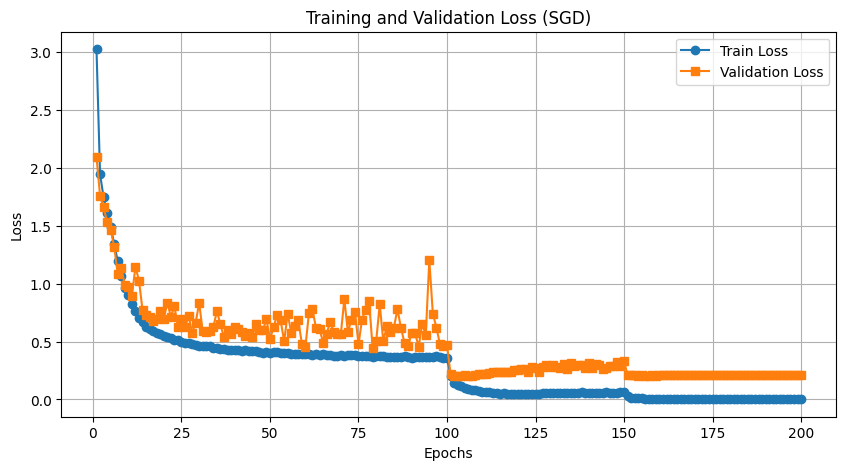

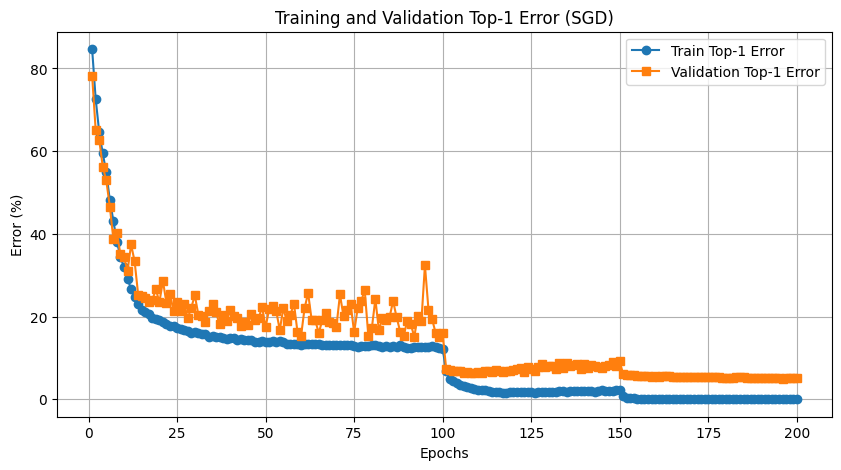

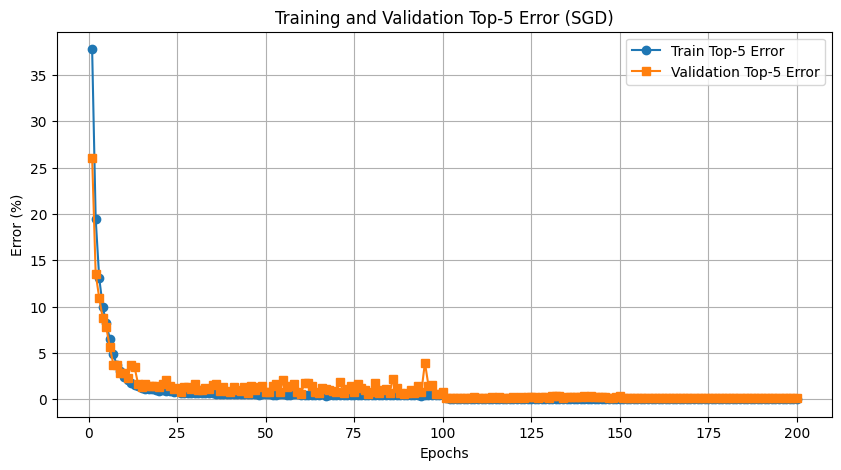

Finished training with SGD.
Best val top1 error: 5.02
Final val top1 error: 5.07
Best val top5 error: 0.13
Final val top5 error: 0.11


In [15]:
Trainer(model2, 'SGD', dataset_name='cifar10', max_epochs=200, random_seed=2025)